In [1]:
import cornac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, sparse

In [2]:
df = pd.read_csv('Data/Reviews-raw.csv').drop(columns=['Unnamed: 0'])
df.head()

,recommendationid,author_id,review,timestamp,voted_up,weighted_vote_score,app_id
0,186781078,76561197960432447,A legendary tactical shooter that shaped the g...,1738278781,True,0.652997,10
1,184974430,76561198071230926,"The best CS sure, but server browser is the il...",1736206418,True,0.581749,10
2,186584044,76561198206216352,Some of the best memories of my childhood were...,1738041574,True,0.628378,10
3,186564689,76561198110801124,This game feels so much better than CS2. I kno...,1738015332,True,0.000000,10
4,186418367,76561199813732773,its very fun to play you can make friends out ...,1737853720,True,0.000000,10


# Data Cleaning

## Duplicated values

There are 2 types of duplicated values:
- Reviews with the same ```recommendationid```
- Reviews with the same values on all columns
- Reviews with the same ```author_id``` and ```app_id```

### Duplicated columns values

In [3]:
dup_all = df[df.duplicated()].sort_values(by='recommendationid')
print(f'Number of rows having duplicated recommendationid: {dup_all.shape[0]:,}')
dup_all.head()

Number of rows having duplicated recommendationid: 596,656


,recommendationid,author_id,review,timestamp,voted_up,weighted_vote_score,app_id
85330,361956,76561197969617806,Never play or buy this game. Ever. No ability ...,1385425897,False,0.500000,11130
173299,765590,76561197977755278,[h1]Grand Theft Auto: Episodes from Liberty Ci...,1658063429,True,0.602504,12220
173399,765590,76561197977755278,[h1]Grand Theft Auto: Episodes from Liberty Ci...,1658063429,True,0.602504,12220
85318,830608,76561197979693740,"This game is old as hell, but not so old as to...",1363127744,True,0.498258,11130
173446,911494,76561197981793213,"Interesting storylines, fun gameplay for main ...",1352853246,True,0.546651,12220


In [4]:
n_rows_before = df.shape[0]
print(f'Number of rows BEFORE removing duplicates: {df.shape[0]:,}')
df.drop_duplicates(inplace=True)
n_rows_after = df.shape[0]
print(f'Number of rows AFTER removing duplicates: {df.shape[0]:,}')
print(f'Total removed rows: {(n_rows_before - n_rows_after):,}')

Number of rows BEFORE removing duplicates: 1,766,443
Number of rows AFTER removing duplicates: 1,169,787
Total removed rows: 596,656


### Duplicated ```recommendationid```

In [5]:
dup_rec_id = df[df['recommendationid'].duplicated(keep=False)]
print(f'Number of rows having duplicated recommendationid: {dup_rec_id.shape[0]:,}')
dup_rec_id

Number of rows having duplicated recommendationid: 27,077


,recommendationid,author_id,review,timestamp,voted_up,weighted_vote_score,app_id
0,186781078,76561197960432447,A legendary tactical shooter that shaped the g...,1738278781,True,0.652997,10
1,184974430,76561198071230926,"The best CS sure, but server browser is the il...",1736206418,True,0.581749,10
2,186584044,76561198206216352,Some of the best memories of my childhood were...,1738041574,True,0.628378,10
236,186781078,76561197960432447,A legendary tactical shooter that shaped the g...,1738278781,True,0.583333,10
237,186584044,76561198206216352,Some of the best memories of my childhood were...,1738041574,True,0.565217,10
...,...,...,...,...,...,...,...
1759198,186772565,76561198027756990,I was about to give this game a rather high ra...,1738271017,False,0.609755,990080
1761395,185987859,76561197995874167,So this game is a continuation of the Trials s...,1737339420,True,0.000000,991270
1761407,185987859,76561197995874167,So this game is a continuation of the Trials s...,1737339420,True,0.523810,991270
1761755,184885224,76561198118627311,Half assed 1.0 release that is extremely disap...,1736122853,False,0.694502,992910


For rows having duplicated ```recommendationid```, some of the columns values are different from each other.
Check if the same ```recommendationid``` has different:
1. ```author_id```
2. ```app_id```
3. ```review```
4. ```timestamp```
5. ```voted_up```
6. ```weighted_vote_score```

In [6]:
def find_diff_dup_rec(col):
    n_col_name = 'n_' + col
    n_col_rec = dup_rec_id.groupby(by=['recommendationid'])[col].nunique().reset_index(name=n_col_name)
    n_rows_multiple_col_value = n_col_rec[n_col_rec[n_col_name] > 1].shape[0]
    if n_rows_multiple_col_value > 0:
        print(f'There are {n_rows_multiple_col_value} rows having the same recommendationid but different {col}')
    else:
        print(f'There are NOT ANY rows having the same recommendationid but different {col}')

In [7]:
find_diff_dup_rec('author_id')
find_diff_dup_rec('app_id')
find_diff_dup_rec('review')
find_diff_dup_rec('timestamp')
find_diff_dup_rec('voted_up')
find_diff_dup_rec('weighted_vote_score')

There are NOT ANY rows having the same recommendationid but different author_id
There are NOT ANY rows having the same recommendationid but different app_id
There are 50 rows having the same recommendationid but different review
There are 49 rows having the same recommendationid but different timestamp
There are 6 rows having the same recommendationid but different voted_up
There are 13493 rows having the same recommendationid but different weighted_vote_score


#### !!! EASY SOLUTION (could be change later)
Remove all of them, just keep the first occurence :)

In [8]:
n_rows_before = df.shape[0]
print(f'Number of rows BEFORE removing duplicates: {df.shape[0]:,}')
df.drop_duplicates(subset=['recommendationid'], inplace=True)
n_rows_after = df.shape[0]
print(f'Number of rows AFTER removing duplicates: {df.shape[0]:,}')
print(f'Total removed rows: {(n_rows_before - n_rows_after):,}')

Number of rows BEFORE removing duplicates: 1,169,787
Number of rows AFTER removing duplicates: 1,156,233
Total removed rows: 13,554


### Duplicated ```author_id```-```app_idd``` pairs

In [12]:
df[df.duplicated(subset=['author_id', 'app_id'])]

,recommendationid,author_id,review,timestamp,voted_up,weighted_vote_score,app_id


In [11]:
df.drop_duplicates(subset=['author_id', 'app_id'], inplace=True)

# Data Exploration

In [41]:
print(f"Number of ratings: {len(df):,}")
print(f"Number of users: {df.author_id.nunique():,}")
print(f"Number of items: {df.app_id.nunique():,}")

Number of ratings: 1,156,233
Number of users: 836,887
Number of items: 69,001


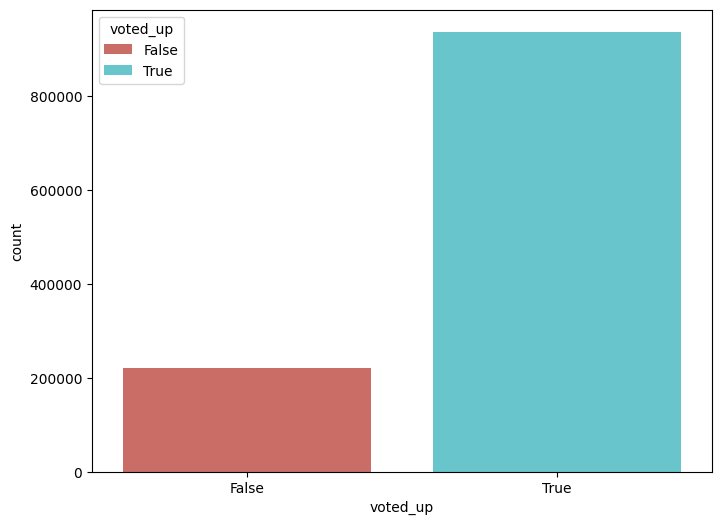

In [42]:
plt.figure(figsize=(8, 6))
color_pallete = sns.color_palette("hls", 2)
sns.countplot(x="voted_up", data=df, palette=color_pallete, hue='voted_up')
plt.show()

In [44]:
n_users = df.author_id.nunique()
n_items = df.app_id.nunique()
n_ratings = len(df)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users:,}")
print(f"Number of items: {n_items:,}")
print(f"Number of available ratings: {n_ratings:,}")
print(f"Number of all possible ratings: {rating_matrix_size:,}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 836,887
Number of items: 69,001
Number of available ratings: 1,156,233
Number of all possible ratings: 57,746,039,887
----------------------------------------
SPARSITY: 100.00%
